---
title: 3 Layer Stacked QG Model
subject: Jax Approximate Ocean Models
# subtitle: How can I estimate the state AND the parameters?
short_title: Stacked QG
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - CNRS
      - MEOM
    orcid: 0000-0002-6739-0053
    email: jemanjohnson34@gmail.com
  - name: Takaya Uchida
    affiliations:
      - FSU
    orcid: https://orcid.org/0000-0002-8654-6009
    email: takachanbo@gmail.com
license: CC-BY-4.0
keywords: jax, shallow water model, differentiable
abbreviations:
    SW: Shallow Water
    QG: Quasi-Geostrophic
    PDE: Partial Differential Equation
    RHS: Right Hand Side
---

In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'FALSE'
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # second gpu


import jax
# again, this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

In [2]:
import autoroot
import typing as tp
import equinox as eqx 
import einops

import math
import diffrax as dfx
from jaxtyping import Array, Float
import jax
import numpy as np
import jax.numpy as jnp
import jax.scipy as jsp
import pandas as pd
from somax.domain import Domain
from somax.masks import MaskGrid
from somax.interp import x_avg_1D, x_avg_2D, y_avg_2D, center_avg_2D
from somax._src.models.qg.params import QGParams
from somax._src.models.qg.domain import LayerDomain
from somax._src.models.qg.elliptical import DSTSolution, calculate_helmholtz_dst, compute_homogeneous_solution

import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)


%matplotlib inline
%load_ext autoreload
%autoreload 2

#### Plot Utils

In [3]:
from loguru import logger


def plot_field(field, name=""):
    num_axis = len(field)
    fig, ax = plt.subplots(ncols=num_axis, figsize=(9, 3))
    vmin, vmax = np.min(field), np.max(field)
    vlim = np.min([np.abs(vmin), np.abs(vmax)])
    fig.suptitle(name)
    for i in range(num_axis):
        pts = ax[i].pcolormesh(field[i].T, cmap="coolwarm", 
                               vmin=-vlim, vmax=vlim, rasterized=True
                              )
        plt.colorbar(pts, shrink=.6)
        ax[i].set_aspect('equal')

    plt.tight_layout()
    plt.show()


def print_debug_quantity(quantity, name=""):
    size = quantity.shape
    min_ = jnp.min(quantity)
    max_ = jnp.max(quantity)
    mean_ = jnp.mean(quantity)
    median_ = jnp.mean(quantity)
    jax.debug.print(
        f"{name}: {size} | {min_:.6e} | {mean_:.6e} | {median_:.6e} | {max_:.6e}"
    )

In [4]:
resolution = 256

In [5]:
# # Low Resolution (Non-Resolving)
Nx, Ny = resolution, resolution
# Nx, Ny = 128, 128
# Low Resolution
# Nx, Ny = 256, 256
# High Resolution
# Nx, Ny = 512, 512
# Nx, Ny = 769, 961

# Lx, Ly = 3840.0e3, 4800.0e3
Lx, Ly = 4_000.0e3, 4_000.0e3
# Lx, Ly = 5_120.0e3, 5_120.0e3


dx, dy = Lx / Nx, Ly / Ny

xy_domain = Domain(
    xmin=(0.0,0.0), 
    xmax=(Lx,Ly),
    Lx=(Lx,Ly),
    Nx=(Nx, Ny), 
    dx=(dx, dy)
)

# params = QGParams(
#     y0=0.5 * Ly, a_2=1.,
# )
# params

In [27]:
diffusivity = 15.0
method = "wenoz" # "wenoz" #  wenoz
num_pts = 5

**Things to Try**:

* Explicity Diffisivity, $a_2=30$
* No Diffusivity, $a_2=0.0$

In [28]:
# explicit diffusivity
params = QGParams(
    y0=0.5 * Ly, 
    a_2=diffusivity, 
    f0=9.4e-05, 
    beta=1.7e-11, 
    tau0=5e-5, 
    # method='arakawa'
    method=method, 
    num_pts=num_pts
)

# # NO diffusivity
# params = QGParams(
#     y0=0.5 * Ly, 
#     a_2=0.0, 
#     f0=9.4e-05, 
#     beta=1.7e-11, 
#     tau0=5e-5, 
#     method='wenoz', 
#     num_pts=5
# )

In [29]:
# params = QGParams(y0=0.5 * Ly, a_2=35., f0=9.4e-05, beta=1.7e-11, tau0=5e-5, method='wenoz', num_pts=3)

# params = QGParams(y0=0.5 * Ly, a_2=45., f0=9.4e-05, beta=1.7e-11, tau0=5e-5, method='arakawa')

In [30]:
xy_domain

Domain(
  xmin=(0.0, 0.0),
  xmax=(4000000.0, 4000000.0),
  dx=(15625.0, 15625.0),
  Nx=(256, 256),
  Lx=(4000000.0, 4000000.0),
  ndim=2
)

In [31]:
# octogonal domain
# domain_type = "octogonal"
# mask = np.ones((Nx-1,Ny-1))
# for i in range(Nx//4):
#     for j in range(Ny//4):
#         if i+j < min(Nx//4, Ny//4):
#             mask[i,j] = 0.
#             mask[i,-1-j] = 0.
#             mask[-1-i,j] = 0.
#             mask[-1-i,-1-j] = 0.
            
# masks = MaskGrid.init_mask(mask, location="center")

domain_type = "rectangular"

mask = jnp.ones((Nx,Ny))
mask = mask.at[0].set(0.0)
mask = mask.at[-1].set(0.0)
mask = mask.at[:,0].set(0.0)
mask = mask.at[:,-1].set(0.0)
masks = MaskGrid.init_mask(mask, location="node")


### Layer Domain

In [32]:
# heights
# heights = [350.0, 750.0, 2900.0]
heights = [400.0, 1_100.0, 2_600.0]

# reduced gravities
reduced_gravities = [0.025, 0.0125]

# initialize layer domain
with jax.default_device(jax.devices("cpu")[0]):
    layer_domain = LayerDomain(heights, reduced_gravities, correction=False)

### Helmoltz

In [33]:

# from jaxsw._src.operators.functional import elliptical as F_elliptical
H_mat = calculate_helmholtz_dst(xy_domain, layer_domain, params)
H_mat.shape

(3, 254, 254)

### Homogeneous Solution

In [34]:
psi0 = jnp.ones(shape=(layer_domain.Nz,) + xy_domain.Nx)

# psi0 = np.load("/Users/eman/code_projects/data/qg_runs/psi_000y_360d.npy")[0]
lambda_sq = params.f0**2 *einops.rearrange(layer_domain.lambda_sq, "Nz -> Nz 1 1")

homsol = compute_homogeneous_solution(
    psi0, 
    lambda_sq=lambda_sq,
    H_mat=H_mat
)
print_debug_quantity(homsol, "HOMSOL")

# calculate homogeneous solution
homsol_i = jax.vmap(center_avg_2D)(homsol) * masks.center.values

homsol_mean = einops.reduce(homsol_i, "Nz Nx Ny -> Nz 1 1", reduction="mean")
print_debug_quantity(homsol_mean, "HOMSOL MEAN")

# CALCULATE CAPCITANCE MATRIX
if domain_type == "octogonal":
    cap_matrices = compute_capacitance_matrices(
        H_mat, 
        masks.node.irrbound_xids,
        masks.node.irrbound_yids
    )
else:
    cap_matrices = None


# DST SOLUTION
dst_sol = DSTSolution(
    homsol=homsol, 
    homsol_mean=homsol_mean, 
    H_mat=H_mat,
    capacitance_matrix=cap_matrices
)

HOMSOL: (3, 256, 256) | -2.365560e-07 | 3.611293e-01 | 3.611293e-01 | 1.000000e+00
HOMSOL MEAN: (3, 1, 1) | 2.656387e-02 | 3.561087e-01 | 3.561087e-01 | 1.000000e+00


### Custom Forcing

In [35]:
from somax._src.models.qg.forcing import calculate_bottom_drag, calculate_wind_forcing

In [36]:
wind_forcing = calculate_wind_forcing(
    domain=xy_domain,
    params=params,
    H_0=layer_domain.heights[0],
    tau0=0.08/1_000.0,
)


def forcing_fn(
    psi: Float[Array, "Nz Nx Ny"],
    dq: Float[Array, "Nz Nx-1 Ny-1"],
    domain: Domain,
    layer_domain: LayerDomain,
    params: QGParams,
    masks: MaskGrid,
) -> Float[Array, "Nz Nx Ny"]:
    
    # add wind forcing
    dq = dq.at[0].add(wind_forcing)
    
    # calculate bottom drag
    bottom_drag = calculate_bottom_drag(
        psi=psi, domain=domain,
        H_z=layer_domain.heights[-1],
        delta_ek=params.delta_ek,
        f0=params.f0,
        masks_psi=masks.node
    )
    

    dq = dq.at[-1].add(bottom_drag)
    
    return dq

### Initial Quantities

In [37]:

from somax._src.models.qg.operators import (
    calculate_potential_vorticity,
    calculate_psi_from_pv,
    equation_of_motion
)

## Equation of Motion

In [38]:
class State(eqx.Module):
    q: Array
    psi: Array

In [39]:
def vector_field(t: float, state: State, args) -> State:
    
    
    
    dq = equation_of_motion(
        q=state.q, psi=state.psi, params=params,
        domain=xy_domain, layer_domain=layer_domain,
        forcing_fn=forcing_fn,
        masks=masks
    )

    dpsi = calculate_psi_from_pv(
        q=dq,
        params=params,
        domain=xy_domain,
        layer_domain=layer_domain,
        mask_node=masks.node,
        dst_sol=dst_sol,
        # include_beta=True
        remove_beta=False
    )
    
    state = eqx.tree_at(lambda x: x.q, state, dq)
    state = eqx.tree_at(lambda x: x.psi, state, dpsi)
    
    return state

## Time Stepping

About 1 year

In [40]:
dt = 4_000 # seconds

tmin = 0.0
num_years = 1
num_days = 360
tmax = pd.to_timedelta(num_years * num_days, unit="days").total_seconds()
num_save = 2

In [41]:
from somax.domain import TimeDomain

t_domain = TimeDomain(tmin=tmin, tmax=tmax, dt=dt)
ts = jnp.linspace(tmin, tmax, num_save)
saveat = dfx.SaveAt(ts=ts)

In [21]:
num_steps = int(tmax / dt)

In [22]:
def ssrk3_update_stage_1(x, x0, dt):
    # self.q += self.dt * dq_0
    return x + dt*x0

def ssrk3_update_stage_2(x, x0, x1, dt):
    # self.q += (self.dt/4)*(dq_1 - 3*dq_0)
    return x + (dt/4) * (x1 - 3*x0)

def ssrk3_update_stage_3(x, x0, x1, x2, dt):
    # self.q += (self.dt/12)*(8*dq_2 - dq_1 - dq_0)
    return x + (dt/12)*(8*x2 - x1 - x0)

def timestepper_ssrk3(t, state, *args):
    """ Time itegration with SSP-RK3 scheme."""

    # compute update (round 1)
    state_1 = vector_field(t, state, None)
    
    q = ssrk3_update_stage_1(state.q, state_1.q, dt)
    psi = ssrk3_update_stage_1(state.psi, state_1.psi, dt)
    
    state = eqx.tree_at(lambda x: x.q, state, q)
    state = eqx.tree_at(lambda x: x.psi, state, psi)

    # dpsi_0, dq_0 = self.compute_time_derivatives()
    # self.q += self.dt * dq_0
    # self.psi += self.dt * dpsi_0


    # compute update (round 2)
    state_2 = vector_field(t, state, None)
    
    q = ssrk3_update_stage_2(state.q, state_1.q, state_2.q, dt)
    psi = ssrk3_update_stage_2(state.psi, state_1.psi, state_2.psi, dt)
    
    state = eqx.tree_at(lambda x: x.q, state, q)
    state = eqx.tree_at(lambda x: x.psi, state, psi)

    # dpsi_1, dq_1 = self.compute_time_derivatives()
    # self.q += (self.dt/4)*(dq_1 - 3*dq_0)
    # self.psi += (self.dt/4)*(dpsi_1 - 3*dpsi_0)

    # compute update (round 3)
    state_3 = vector_field(t, state, None)
    
    q = ssrk3_update_stage_3(state.q, state_1.q, state_2.q, state_3.q, dt)
    psi = ssrk3_update_stage_3(state.psi, state_1.psi, state_2.psi, state_3.psi, dt)
    
    state = eqx.tree_at(lambda x: x.q, state, q)
    state = eqx.tree_at(lambda x: x.psi, state, psi)

    # dpsi_2, dq_2 = self.compute_time_derivatives()
    # self.q += (self.dt/12)*(8*dq_2 - dq_1 - dq_0)
    # self.psi += (self.dt/12)*(8*dpsi_2 - dpsi_1 - dpsi_0)

    return state

    


    # # compute update (round 2)
    # state_2 = vector_field(t, state)
    # state = eqx.tree_at(lambda x: x.q + dt * x.q, state, state_2)
    # state = eqx.tree_at(lambda x: x.psi + dt * x.psi, state, state_2)
    






In [23]:
psi0 = jnp.zeros(shape=(layer_domain.Nz,) + xy_domain.Nx)
# psi0 = np.load("/Users/eman/code_projects/data/qg_runs/psi_0.986y_360.00d_octogonal.npy")

q0 = calculate_potential_vorticity(
    psi0, xy_domain, layer_domain, 
    params=params,
    masks_psi=masks.node, 
    masks_q=masks.center
)

state = State(q=q0, psi=psi0)

In [24]:
def apply_timestep(state, step):
    """
    - `res`: The result from the previous loop.
    - `el`: The current array element.
    """
    state = timestepper_ssrk3(0, state, None)
    return state, None  # ("carryover", "accumulated")

In [25]:
all_steps = jnp.asarray(list(range(num_steps)))

In [26]:
%%time

from jax import lax

state = State(q=q0, psi=psi0)
final, result = lax.scan(apply_timestep, init=state, xs=all_steps)

CPU times: user 1min 8s, sys: 2min 5s, total: 3min 13s
Wall time: 3min 11s


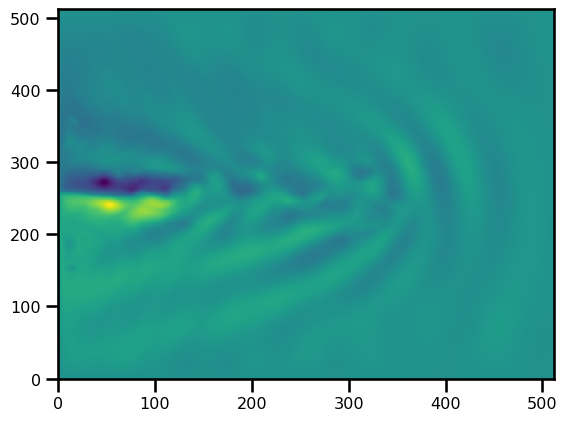

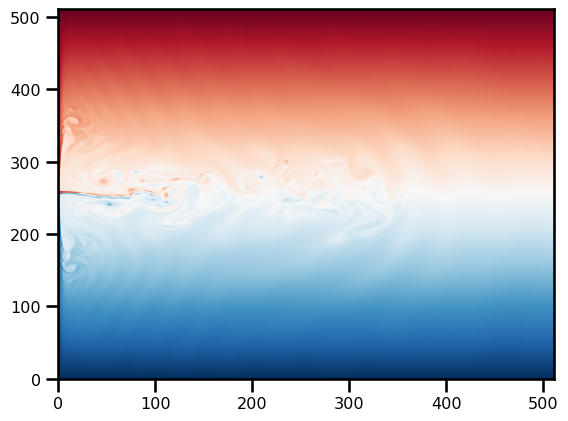

In [27]:
# state

plt.pcolormesh(final.psi[-1].T, cmap="viridis")
plt.show()
plt.pcolormesh(final.q[-1].T, cmap="RdBu_r")
plt.show()

In [28]:
%%time

final, result = lax.scan(apply_timestep, init=final, xs=all_steps)

CPU times: user 1min 1s, sys: 2min 4s, total: 3min 5s
Wall time: 3min 7s


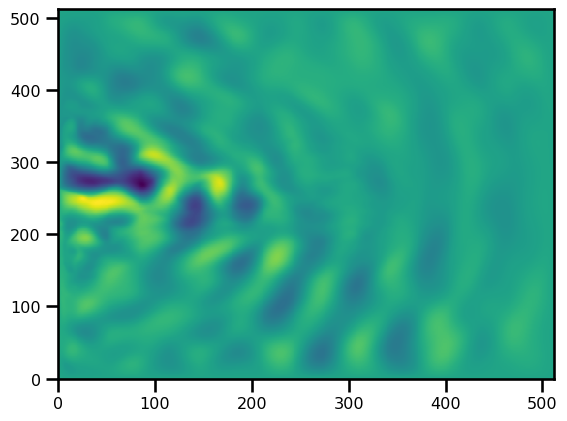

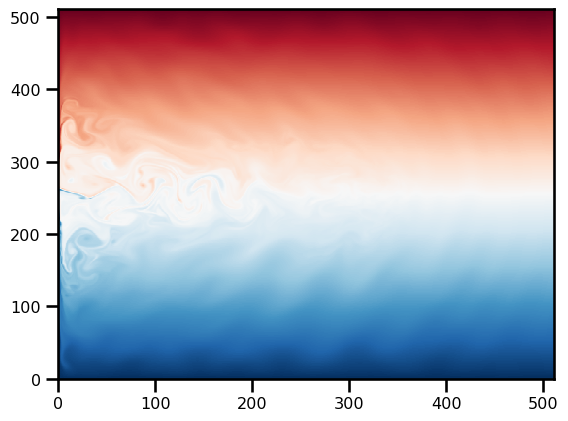

In [29]:
# state

plt.pcolormesh(final.psi[-1].T, cmap="viridis")
plt.show()
plt.pcolormesh(final.q[-1].T, cmap="RdBu_r")
plt.show()

In [30]:
%%time
from tqdm.auto import tqdm, trange
from functools import partial

pbar = trange(num_steps)

# fn = partial(timestepper_ssrk3, t=0, args=None)
fn = jax.jit(timestepper_ssrk3)

for istep in pbar:
    state = fn(0, state, None)

  0%|          | 0/7776 [00:00<?, ?it/s]

CPU times: user 1min 8s, sys: 1min 56s, total: 3min 5s
Wall time: 3min 1s


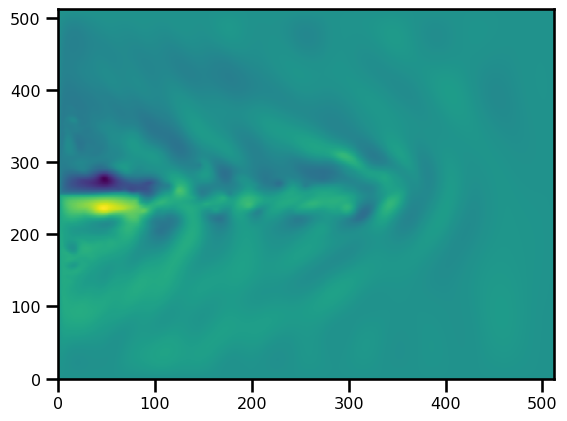

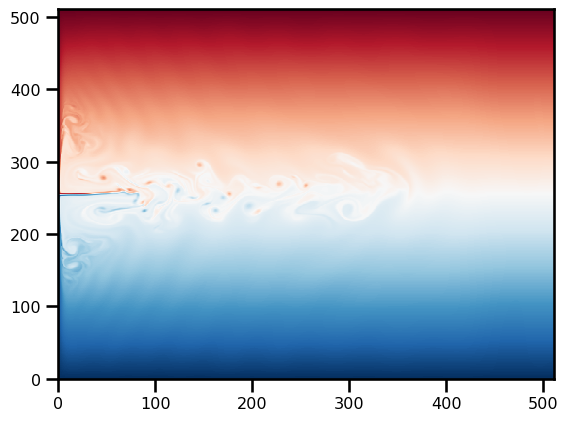

In [31]:
# state

plt.pcolormesh(state.psi[-1].T, cmap="viridis")
plt.show()
plt.pcolormesh(state.q[-1].T, cmap="RdBu_r")
plt.show()

In [32]:
%%time
from tqdm.auto import tqdm, trange
from functools import partial

pbar = trange(num_steps)

# fn = partial(timestepper_ssrk3, t=0, args=None)
fn = jax.jit(timestepper_ssrk3)

for istep in pbar:
    state = fn(0, state, None)

  0%|          | 0/7776 [00:00<?, ?it/s]

CPU times: user 1min 2s, sys: 1min 54s, total: 2min 56s
Wall time: 2min 57s


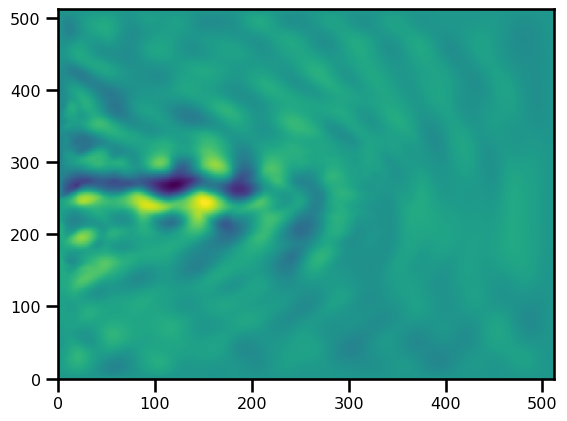

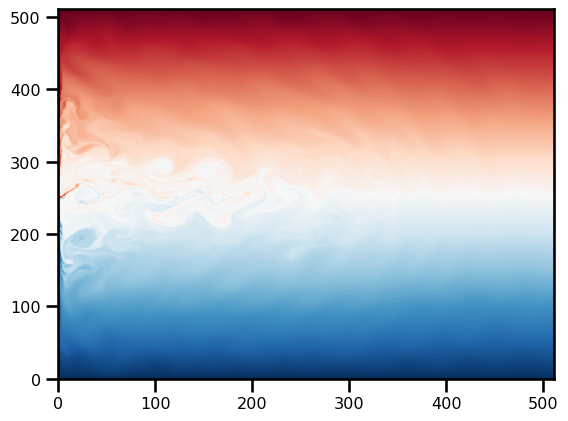

In [33]:
# state

plt.pcolormesh(state.psi[-1].T, cmap="viridis")
plt.show()
plt.pcolormesh(state.q[-1].T, cmap="RdBu_r")
plt.show()

In [42]:
# Euler, Constant StepSize
# solver = dfx.Tsit5()
# solver = dfx.Heun()
solver = dfx.Bosh3()

# Tolerances
# stepsize_controller = dfx.PIDController(rtol=1e-4, atol=1e-4)
stepsize_controller = dfx.ConstantStepSize()

In [43]:
psi0 = jnp.zeros(shape=(layer_domain.Nz,) + xy_domain.Nx)
# psi0 = np.load("/Users/eman/code_projects/data/qg_runs/psi_0.986y_360.00d_octogonal.npy")

q0 = calculate_potential_vorticity(
    psi0, xy_domain, layer_domain, 
    params=params,
    masks_psi=masks.node, 
    masks_q=masks.center
)

state_init = State(q=q0, psi=psi0)

  0%|          | 0/2 [00:00<?, ?it/s]

Year - 0 | Time Taken - 54.98 secs


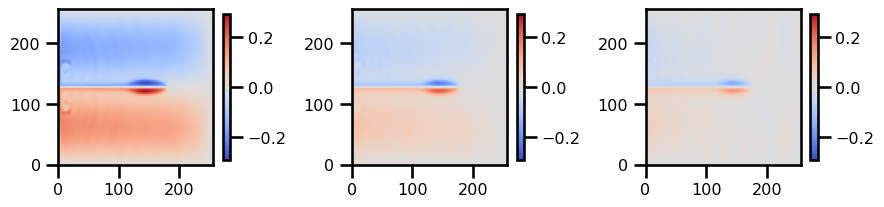

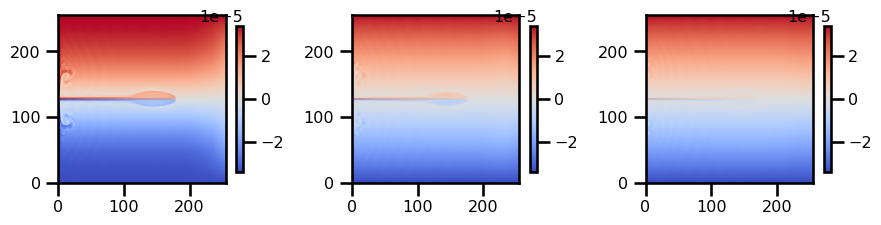

Year - 1 | Time Taken - 51.28 secs


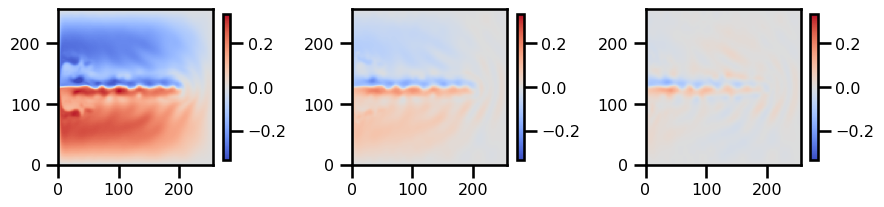

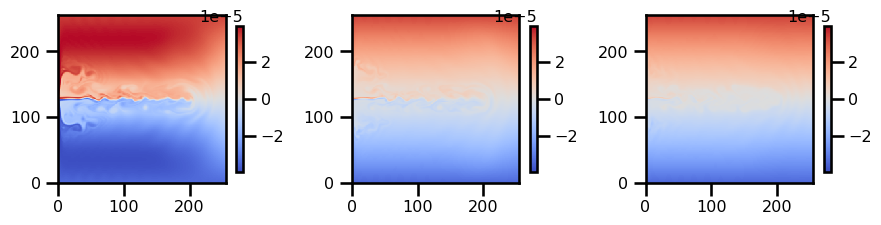

In [44]:
from tqdm.auto import trange
import time

num_years = 2
pbar = trange(num_years)

for iyear in pbar:

    t0 = time.time()

    pbar.set_description(f"Year - {iyear}")

    # integration
    sol = dfx.diffeqsolve(
        terms=dfx.ODETerm(vector_field),
        solver=solver,
        t0=tmin,
        t1=tmax,
        dt0=dt,
        y0=state_init,
        saveat=saveat,
        args=None,
        stepsize_controller=stepsize_controller,
        max_steps=None,
    )
    t1 = time.time() - t0
    print(f"Year - {iyear} | Time Taken - {t1:.2f} secs")
    plot_field(sol.ys.psi[-1]/ (9.81 / params.f0))
    plot_field(sol.ys.q[-1])

    state_init = State(q=sol.ys.q[-1], psi=sol.ys.psi[-1])

    
    

In [37]:
import xarray as xr
ds = xr.Dataset()

In [38]:
sol.ys.q[-1].shape, sol.ys.psi[-1].shape

((3, 511, 511), (3, 512, 512))

In [54]:
ids = xr.Dataset(
    {
        "q": (("z", "x_center", "y_center"), sol.ys.q[-1]),
        "psi": (("z", "x_node", "y_node"), sol.ys.psi[-1]),
    },
    coords={
        "x_node": xy_domain.coords_axis[0],
        "y_node": xy_domain.coords_axis[1],
        "time": iyear,
        "diffusivity": diffusivity,
        "method": method,
        "num_pts": num_pts,
        "resolution": resolution
    }
)

ids

<xarray.Dataset> Size: 195kB
Dimensions:      (z: 3, x_center: 63, y_center: 63, x_node: 64, y_node: 64)
Coordinates:
  * x_node       (x_node) float64 512B 0.0 6.349e+04 ... 3.937e+06 4e+06
  * y_node       (y_node) float64 512B 0.0 6.349e+04 ... 3.937e+06 4e+06
    time         int64 8B 0
    diffusivity  int64 8B 30
    method       <U6 24B 'linear'
    num_pts      int64 8B 3
    resolution   int64 8B 64
Dimensions without coordinates: z, x_center, y_center
Data variables:
    q            (z, x_center, y_center) float64 95kB -3.387e-05 ... 3.342e-05
    psi          (z, x_node, y_node) float64 98kB 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [49]:
.shape

(64,)